In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
def preprocess_text(text):
   
    if isinstance(text, str):
        #lemmatizer = WordNetLemmatizer()
        text = text.lower()
        text = re.sub(r'http\S+','', text) #Remove URLs
        text = re.sub(r'@\w+', '', text) #remove @
        text = re.sub(r'#\w+','', text) #remove hashtag        
        tokens = re.findall(r'\b\w+\b', text)        
        tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS]
        return ' '.join(tokens)
    else:
        return ""

In [3]:
import re

def clean_text_advanced(text):
    text = text.lower()
    text = re.sub(r'http\S+','', text) #Remove URLs
    # Remove HTML entities like amp, quot
    text = re.sub(r'&\w+;', '', text)
    # Remove single characters (like s, t, m)
    text = re.sub(r'\b[a-zA-Z]\b', '', text)
    # Expand contractions (basic)
    text = text.replace("n't", " not").replace("'re", " are").replace("'m", " am").replace("'s", " is")
    # Remove punctuation/numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text



In [4]:
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\irfan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\irfan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Training Sentiment Dataset: 
### Dateset: Sentiment140 Dataset
#### https://www.kaggle.com/datasets/kazanova/sentiment140/data
#### Size:  (238.8 MB)
#### the polarity of the tweet (0 = negative, --no neutral--, 4 = positive)
#### Time Stamp: 2009


In [5]:
df=pd.read_csv('Sentiment140.csv',encoding = 'latin',header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df.info()
display(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df = df[["text", "target"]]
#df['cleaned_text'] = df['text'].apply(preprocess_text)
df['cleaned_text'] = df['text'].apply(clean_text_advanced)
df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)

In [7]:
df.head()

,text,target,cleaned_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,switchfoot awww that bummer you shoulda got da...
1,is upset that he can't update his Facebook by ...,0,is upset that he can update his facebook by te...
2,@Kenichan I dived many times for the ball. Man...,0,kenichan dived many time for the ball managed ...
3,my whole body feels itchy and like its on fire,0,my whole body feel itchy and like it on fire
4,"@nationwideclass no, it's not behaving at all....",0,nationwideclass no it not behaving at all mad ...


### Test 1. Process balanced dataset
### https://www.kaggle.com/datasets/arun4545/all-in-one-sentiment-dataset

In [8]:
balanced_sentiment = pd.read_csv('balanced_sentiment_dataset.csv')
print(balanced_sentiment.head())
# Replace 4 with 1 in target column 'Sentiment'
balanced_sentiment['sentiment'] = balanced_sentiment['sentiment'].replace({1: 4})
print(balanced_sentiment.info())

#balanced_sentiment['cleaned_text'] = balanced_sentiment['text'].apply(preprocess_text)
balanced_sentiment['cleaned_text'] = balanced_sentiment['text'].apply(clean_text_advanced)
balanced_sentiment['cleaned_text'] = balanced_sentiment['cleaned_text'].apply(lemmatize_text)

balanced_sentiment.rename(columns={'sentiment': 'target'}, inplace=True)


   sentiment                                               text
0          1  And here is the rap song "African Warrior Quee...
1          1  We asked chatGPT ,\n\nHow to become a successf...
2          0  When I finally manage to convince myself to pe...
3          0  Although a healthier alternative to your typic...
4          1  In my latest test, I asked #ChatGPT to write m...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  80000 non-null  int64 
 1   text       80000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.2+ MB
None


### Test 2: Million Dataset
### https://www.kaggle.com/datasets/tariqsays/sentiment-dataset-with-1-million-tweets

In [9]:
million_sentiment = pd.read_csv('milliondataset.csv')
print(million_sentiment.head())
# Filter rows with Language = 'en'
million_sentiment = million_sentiment[(million_sentiment['Language'] == 'en') & (million_sentiment['Label'].isin(['positive', 'negative']))]

# Reset index (optional)
million_sentiment = million_sentiment.reset_index(drop=True)
million_sentiment['target'] = million_sentiment['Label'].map({'negative': 0, 'positive': 4})
million_sentiment = million_sentiment.drop(columns=['Label', 'Language'])

#million_sentiment['cleaned_text'] = million_sentiment['Text'].apply(preprocess_text)
million_sentiment['cleaned_text'] = million_sentiment['Text'].apply(clean_text_advanced)
million_sentiment['cleaned_text'] = million_sentiment['cleaned_text'].apply(lemmatize_text)



                                                Text Language      Label
0  @Charlie_Corley @Kristine1G @amyklobuchar @Sty...       en  litigious
1  #BadBunny: Como dos gotas de agua: Joven se di...       es   negative
2  https://t.co/YJNiO0p1JV Flagstar Bank disclose...       en  litigious
3  Rwanda is set to host the headquarters of Unit...       en   positive
4  OOPS. I typed her name incorrectly (today’s br...       en  litigious


## Logistic Regression Test With CountVectorization

### CountVectorization With MainDataset: df

#### Build Model using main dataset 

In [10]:
# Use Count Vectorization & Apply Logistic Regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Create Bag of Words vectorizer
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text'].astype(str))
y = df['target']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the Logistic Regression Classifier
lr_classifier = LogisticRegression(random_state=42, max_iter=300, class_weight='balanced')

# Train the model
lr_classifier.fit(X_train, y_train)

# Make predictions
lr_pred = lr_classifier.predict(X_test)

# Print evaluation metrics
print("Accuracy Score:", accuracy_score(y_test, lr_pred))
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))



Accuracy Score: 0.7871229166666667

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78    239361
           4       0.78      0.81      0.79    240639

    accuracy                           0.79    480000
   macro avg       0.79      0.79      0.79    480000
weighted avg       0.79      0.79      0.79    480000



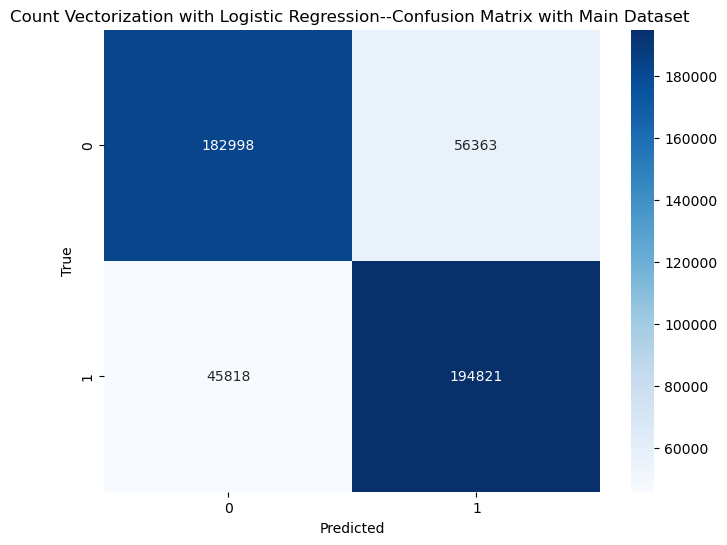

In [11]:
# Create and plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, lr_pred), 
            annot=True, 
            fmt='d',
            cmap='Blues')
plt.title('Count Vectorization with Logistic Regression--Confusion Matrix with Main Dataset ')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Test Model With Count Vectorization

### Count Vectorization with Dataset: balanced_sentiment

In [12]:
#from sklearn.model_selection import cross_val_predict
#vectorizer_balanced = CountVectorizer()
X_balanced = vectorizer.transform(balanced_sentiment['cleaned_text'].astype(str))
y_balanced = balanced_sentiment['target']

predicted_train_cv = cross_val_predict(lr_classifier, X_train, y_train, cv=5)

# Make predictions

lr_pred_new  = lr_classifier.predict(X_balanced)


# Print evaluation metrics
print("Accuracy Score for Balanced Dataset:", accuracy_score(balanced_sentiment['target'], lr_pred_new))
print("\nClassification Report for Balanced Dataset:")
print(classification_report(balanced_sentiment['target'], lr_pred_new))



Accuracy Score for Balanced Dataset: 0.7115875

Classification Report for Balanced Dataset:
              precision    recall  f1-score   support

           0       0.76      0.62      0.68     40000
           4       0.68      0.80      0.73     40000

    accuracy                           0.71     80000
   macro avg       0.72      0.71      0.71     80000
weighted avg       0.72      0.71      0.71     80000



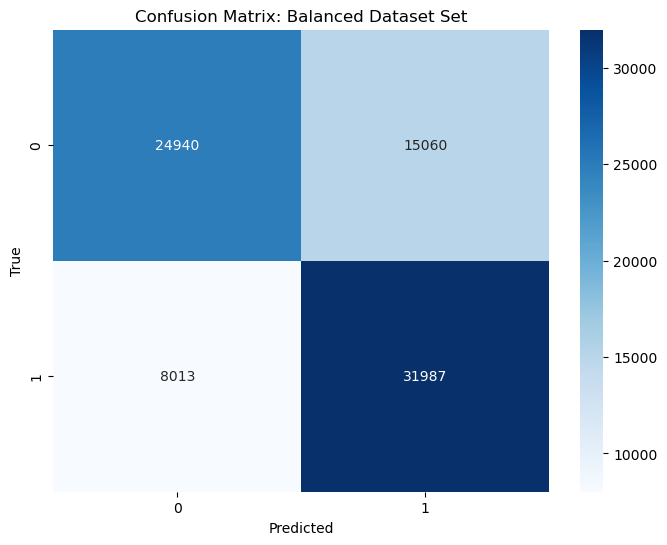

In [13]:
# Create and plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(balanced_sentiment['target'], lr_pred_new), 
           annot=True, 
            fmt='d',
            cmap='Blues')
plt.title('Confusion Matrix: Balanced Dataset Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Count Vectorization with Dataset: million sentiment

In [14]:
#vectorizer_balanced = CountVectorizer()
X_million = vectorizer.transform(million_sentiment['cleaned_text'].astype(str))
y_million = million_sentiment['target']

# Make predictions

lr_pred_million  = lr_classifier.predict(X_million)


# Print evaluation metrics
print("Accuracy Score on Million Dataset:", accuracy_score(million_sentiment['target'], lr_pred_million))
print("\nClassification Report - Million Dataset:")
print(classification_report(million_sentiment['target'], lr_pred_million))



Accuracy Score on Million Dataset: 0.7686080923635271

Classification Report - Million Dataset:
              precision    recall  f1-score   support

           0       0.79      0.72      0.76    244146
           4       0.75      0.81      0.78    248516

    accuracy                           0.77    492662
   macro avg       0.77      0.77      0.77    492662
weighted avg       0.77      0.77      0.77    492662



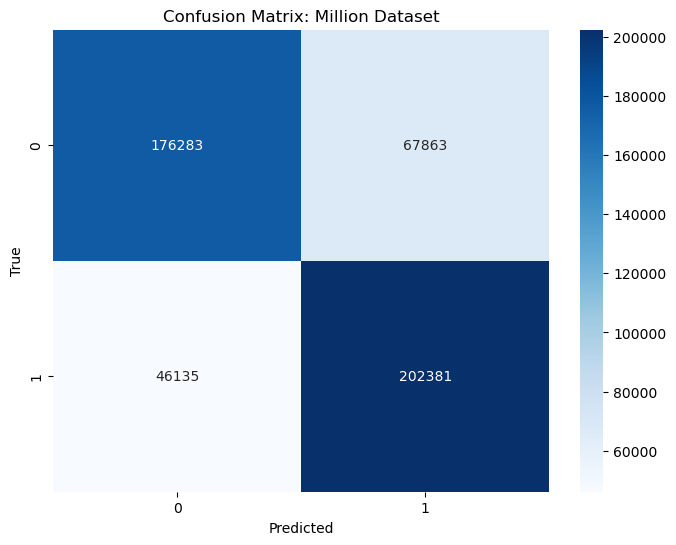

In [15]:
# Create and plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(million_sentiment['target'], lr_pred_million), 
           annot=True, 
            fmt='d',
            cmap='Blues')
plt.title('Confusion Matrix: Million Dataset')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Logistic Regression with TF-IDF

### Build Model Using Test Dataset : df

In [16]:
# --- TF-IDF Vectorization and Logistic Regression with Cross-Validation ---
#TFIDF with logistics regression


# Vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
X_idf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

y_idf = df['target']

X_idf_train, X_idf_test, y_idf_train, y_idf_test = train_test_split(X_idf, y_idf, test_size=0.2, random_state=42)


# Model training

model_idf = LogisticRegression(random_state=42, max_iter=300, class_weight='balanced')
model_idf.fit(X_idf_train, y_idf_train)

model_idf_pred = model_idf.predict( X_idf_test)
print("Test Dataset of df:", accuracy_score(y_idf_test, model_idf_pred))
print(classification_report(y_idf_test, model_idf_pred))

Test Dataset of df: 0.8141375
              precision    recall  f1-score   support

           0       0.82      0.80      0.81    159494
           4       0.81      0.83      0.82    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



## Test Model With TF-IDF

#### Test with Balanced Dataset

In [17]:
X_balanced = tfidf_vectorizer.transform(balanced_sentiment['cleaned_text'].astype(str))
y_balanced = balanced_sentiment['target']


#TFIDF with logistics regression
predicted_train_idf_balanced = cross_val_predict(model_idf, X_idf_train, y_idf_train, cv=10)


# Make predictions

model_idf_pred_balanced  =  model_idf.predict(X_balanced)


# Print evaluation metrics
print("Accuracy Score for TF-IDF:", accuracy_score(balanced_sentiment['target'], model_idf_pred_balanced))
print("\nClassification Report : YF-IDF:")
print(classification_report(balanced_sentiment['target'], model_idf_pred_balanced))

Accuracy Score for TF-IDF: 0.7303625

Classification Report : YF-IDF:
              precision    recall  f1-score   support

           0       0.78      0.63      0.70     40000
           4       0.69      0.83      0.75     40000

    accuracy                           0.73     80000
   macro avg       0.74      0.73      0.73     80000
weighted avg       0.74      0.73      0.73     80000



#### Test with Million Dataset



In [18]:
#TFIDF with logistics regression
#vectorizer_balanced = CountVectorizer()
X_million = tfidf_vectorizer.transform(million_sentiment['cleaned_text'].astype(str))
y_million = million_sentiment['target']

model_idf_pred_million  = model_idf.predict(X_million)


# Print evaluation metrics
print("Accuracy Score for TF-IDF:", accuracy_score(million_sentiment['target'], model_idf_pred_million))
print("\nClassification Report:")
print(classification_report(million_sentiment['target'], model_idf_pred_million))

Accuracy Score for TF-IDF: 0.7625106056484974

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.74    244146
           4       0.74      0.83      0.78    248516

    accuracy                           0.76    492662
   macro avg       0.77      0.76      0.76    492662
weighted avg       0.77      0.76      0.76    492662



## Naive Bayes with TF-IDF

### Build Model with Naive Bayes with TF-IDF using Base Dataset: df

In [19]:
'''
Declared Before
# Vectorization with TF-IDF
#tfidf_vectorizer = TfidfVectorizer(max_features=5000)
#X_idf = tfidf_vectorizer.fit_transform(df['cleaned_text'])
#y_idf = df['target']
#X_idf_train, X_idf_test, y_idf_train, y_idf_test = train_test_split(X_idf, y_idf, test_size=0.3, random_state=42)
'''

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_idf_train, y_idf_train)

nb_model_idf_pred = nb_model.predict( X_idf_test)

print("Base Dataset df Accuracy-Naive Bayes:", accuracy_score(y_idf_test, nb_model_idf_pred))
print(classification_report(y_idf_test, nb_model_idf_pred))

Base Dataset df Accuracy-Naive Bayes: 0.794565625
              precision    recall  f1-score   support

           0       0.79      0.80      0.80    159494
           4       0.80      0.79      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



###  Test Model with Balanced Dataset

In [20]:
#Naive Bayes with TF-IDF
predicted_train_nb_balanced = cross_val_predict(nb_model, X_idf_train, y_idf_train, cv=10)

# Make predictions

nb_model_idf_balanced  = nb_model.predict(X_balanced)

# Print evaluation metrics
print("Accuracy Score of Balanced Dataset:", accuracy_score(balanced_sentiment['target'], nb_model_idf_balanced))
print("\nClassification Report:")
print(classification_report(balanced_sentiment['target'], nb_model_idf_balanced))

Accuracy Score of Balanced Dataset: 0.6972625

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.53      0.64     40000
           4       0.65      0.86      0.74     40000

    accuracy                           0.70     80000
   macro avg       0.72      0.70      0.69     80000
weighted avg       0.72      0.70      0.69     80000



### Test Model with Millions Dataset

In [21]:

nb_idf_pred_million  = nb_model.predict(X_million)

# Print evaluation metrics
print("Accuracy Score Million Dataset:", accuracy_score(million_sentiment['target'], nb_idf_pred_million))
print("\nClassification Report:")
print(classification_report(million_sentiment['target'], nb_idf_pred_million))

Accuracy Score Million Dataset: 0.7387092976523458

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.66      0.72    244146
           4       0.71      0.81      0.76    248516

    accuracy                           0.74    492662
   macro avg       0.74      0.74      0.74    492662
weighted avg       0.74      0.74      0.74    492662



## SVC with TF-IDF

### Build Model with SVC with TF-IDF using Base Dataset: df

In [22]:
# Train Linear SVC
svc_model = LinearSVC()
svc_model.fit(X_idf_train, y_idf_train)

svc_model_idf_pred = svc_model.predict( X_idf_test)

print("SVC Accuracy of Base Dataset df:", accuracy_score(y_idf_test, svc_model_idf_pred))
print(classification_report(y_idf_test, svc_model_idf_pred))

SVC Accuracy of Base Dataset df: 0.81438125
              precision    recall  f1-score   support

           0       0.82      0.80      0.81    159494
           4       0.81      0.83      0.82    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



### Test SVC with Balanced dataset 

In [23]:
#SVC Bayes with TF-IDF
predicted_train_svc_balanced = cross_val_predict(svc_model, X_idf_train, y_idf_train, cv=5)


# Make predictions

svc_model_idf_balanced  = svc_model.predict(X_balanced)


# Print evaluation metrics
print("Accuracy Score of Balanced Dataset using SVC:", accuracy_score(balanced_sentiment['target'], svc_model_idf_balanced))
print("\nClassification Report:")
print(classification_report(balanced_sentiment['target'], svc_model_idf_balanced))

Accuracy Score of Balanced Dataset using SVC: 0.7302125

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.65      0.71     40000
           4       0.70      0.81      0.75     40000

    accuracy                           0.73     80000
   macro avg       0.74      0.73      0.73     80000
weighted avg       0.74      0.73      0.73     80000



### Test SVC with Millions dataset 

In [24]:

svc_idf_pred_million  = svc_model.predict(X_million)

# Print evaluation metrics
print("Accuracy Score:", accuracy_score(million_sentiment['target'], svc_idf_pred_million))
print("\nClassification Report:")
print(classification_report(million_sentiment['target'], svc_idf_pred_million))

Accuracy Score: 0.7416098663992757

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72    244146
           4       0.71      0.81      0.76    248516

    accuracy                           0.74    492662
   macro avg       0.75      0.74      0.74    492662
weighted avg       0.75      0.74      0.74    492662



In [25]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# ------------------------------------------------------
# 1. Predictions & True Labels (your variable names)
# ------------------------------------------------------

# Logistic Regression predictions with Count Vectorization
pred_lr_base = lr_pred
pred_lr_balanced = lr_pred_new
pred_lr_million = lr_pred_million

# Logistic Regression predictions with TF-IDF
pred_lr_idf_base = model_idf_pred
pred_lr_idf_balanced = model_idf_pred_balanced
pred_lr_idf_million = model_idf_pred_million

# Naive Bayes predictions
pred_nb_base = nb_model_idf_pred
pred_nb_balanced = nb_model_idf_balanced
pred_nb_million = nb_idf_pred_million

# SVC predictions
pred_svc_base = svc_model_idf_pred
pred_svc_balanced = svc_model_idf_balanced
pred_svc_million = svc_idf_pred_million

# True labels
y_base_count = y_test
y_base_idf = y_idf_test
y_balanced = balanced_sentiment['target']
y_million = million_sentiment['target']

# ------------------------------------------------------
# 2. Function to Extract Metrics (auto-align lengths)
# ------------------------------------------------------
def extract_metrics(y_true, y_pred):
    # Align lengths to avoid mismatches
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    return acc, report['0'], report['4']   # Only Class 0 and 4

# ------------------------------------------------------
# 3. Build Metrics Dictionary
# ------------------------------------------------------
models = {
    "Logistic Regression-Count Vectorization": [pred_lr_base, pred_lr_balanced, pred_lr_million],
    "Logistic Regression-TF-IDF": [pred_lr_idf_base, pred_lr_idf_balanced, pred_lr_idf_million],
    "Naive Bayes": [pred_nb_base, pred_nb_balanced, pred_nb_million],
    "SVC": [pred_svc_base, pred_svc_balanced, pred_svc_million]
}

datasets = ["Base Dataset", "Balanced Dataset", "Millions Dataset"]

accuracy_data = {}
classification_data = {}

for model_name, preds in models.items():
    acc_scores = []
    neg_metrics = []  # Negative (was Class 0)
    pos_metrics = []  # Positive (was Class 4)

    for idx, pred in enumerate(preds):
        # Use y_base_count for Count Vectorization, else y_base_idf
        if "Count" in model_name:
            y_true = [y_base_count, y_balanced, y_million][idx]
        else:
            y_true = [y_base_idf, y_balanced, y_million][idx]

        if pred is not None:
            acc, c0, c4 = extract_metrics(y_true, pred)
            acc_scores.append(acc)
            neg_metrics.append([c0['precision'], c0['recall'], c0['f1-score']])
            pos_metrics.append([c4['precision'], c4['recall'], c4['f1-score']])
        else:
            acc_scores.append(None)
            neg_metrics.append([None, None, None])
            pos_metrics.append([None, None, None])

    accuracy_data[model_name] = acc_scores
    classification_data[model_name] = {
        "Negative": neg_metrics,
        "Positive": pos_metrics
    }

# ------------------------------------------------------
# 4. Styled Accuracy Summary Table (No Average Row)
# ------------------------------------------------------
df_accuracy = pd.DataFrame(accuracy_data, index=datasets)

# Replace None with NaN for safe formatting
df_accuracy = df_accuracy.replace({None: np.nan})

# Identify numeric columns
numeric_cols_acc = df_accuracy.select_dtypes(include=[np.number]).columns

# Function to highlight max per row
def highlight_max_row(s):
    is_max = s == s.max(skipna=True)
    return ['background-color: gold' if v else '' for v in is_max]

styled_accuracy = (
    df_accuracy.style
    .apply(highlight_max_row, axis=1, subset=numeric_cols_acc)
    .format(subset=numeric_cols_acc, formatter="{:.2%}")  # percentage format
    .background_gradient(cmap="Blues", subset=numeric_cols_acc)  # blue gradient
    .set_caption("Model Accuracy Comparison (Best Highlighted)")
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'),
                                          ('color', '#2a3f5f'),
                                          ('font-weight', 'bold'),
                                          ('text-align', 'center')]}
    ])
)
display(styled_accuracy)

# ------------------------------------------------------
# 5. Styled Classification Metrics Summary Table
# ------------------------------------------------------
rows = []
for dataset_idx, dataset in enumerate(datasets):
    for cls in ["Negative", "Positive"]:  # Updated labels
        row = {"Dataset": dataset, "Class": cls}
        for model_name, metrics in classification_data.items():
            row[f"{model_name} Precision"] = metrics[cls][dataset_idx][0]
            row[f"{model_name} Recall"] = metrics[cls][dataset_idx][1]
            row[f"{model_name} F1-Score"] = metrics[cls][dataset_idx][2]
        rows.append(row)

df_classification = pd.DataFrame(rows)

# Replace None with NaN for safe formatting
df_classification = df_classification.replace({None: np.nan})

# Identify numeric columns
numeric_cols_class = df_classification.select_dtypes(include=[np.number]).columns

styled_classification = (
    df_classification.style
    .format(subset=numeric_cols_class, formatter="{:.2f}")  # 2 decimals
    .background_gradient(cmap="Greens", subset=numeric_cols_class)  # green gradient
    .set_caption("Detailed Classification Metrics (Negative vs Positive)")
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'),
                                          ('color', '#2a3f5f'),
                                          ('font-weight', 'bold'),
                                          ('text-align', 'center')]}
    ])
)
display(styled_classification)


,Logistic Regression-Count Vectorization,Logistic Regression-TF-IDF,Naive Bayes,SVC
Base Dataset,78.71%,81.41%,79.46%,81.44%
Balanced Dataset,71.16%,73.04%,69.73%,73.02%
Millions Dataset,76.86%,76.25%,73.87%,74.16%


,Dataset,Class,Logistic Regression-Count Vectorization Precision,Logistic Regression-Count Vectorization Recall,Logistic Regression-Count Vectorization F1-Score,Logistic Regression-TF-IDF Precision,Logistic Regression-TF-IDF Recall,Logistic Regression-TF-IDF F1-Score,Naive Bayes Precision,Naive Bayes Recall,Naive Bayes F1-Score,SVC Precision,SVC Recall,SVC F1-Score
0,Base Dataset,Negative,0.80,0.76,0.78,0.82,0.80,0.81,0.79,0.80,0.80,0.82,0.80,0.81
1,Base Dataset,Positive,0.78,0.81,0.79,0.81,0.83,0.82,0.80,0.79,0.79,0.81,0.83,0.82
2,Balanced Dataset,Negative,0.76,0.62,0.68,0.78,0.63,0.70,0.79,0.53,0.64,0.78,0.65,0.71
3,Balanced Dataset,Positive,0.68,0.80,0.73,0.69,0.83,0.75,0.65,0.86,0.74,0.70,0.81,0.75
4,Millions Dataset,Negative,0.79,0.72,0.76,0.80,0.70,0.74,0.78,0.66,0.72,0.78,0.67,0.72
5,Millions Dataset,Positive,0.75,0.81,0.78,0.74,0.83,0.78,0.71,0.81,0.76,0.71,0.81,0.76


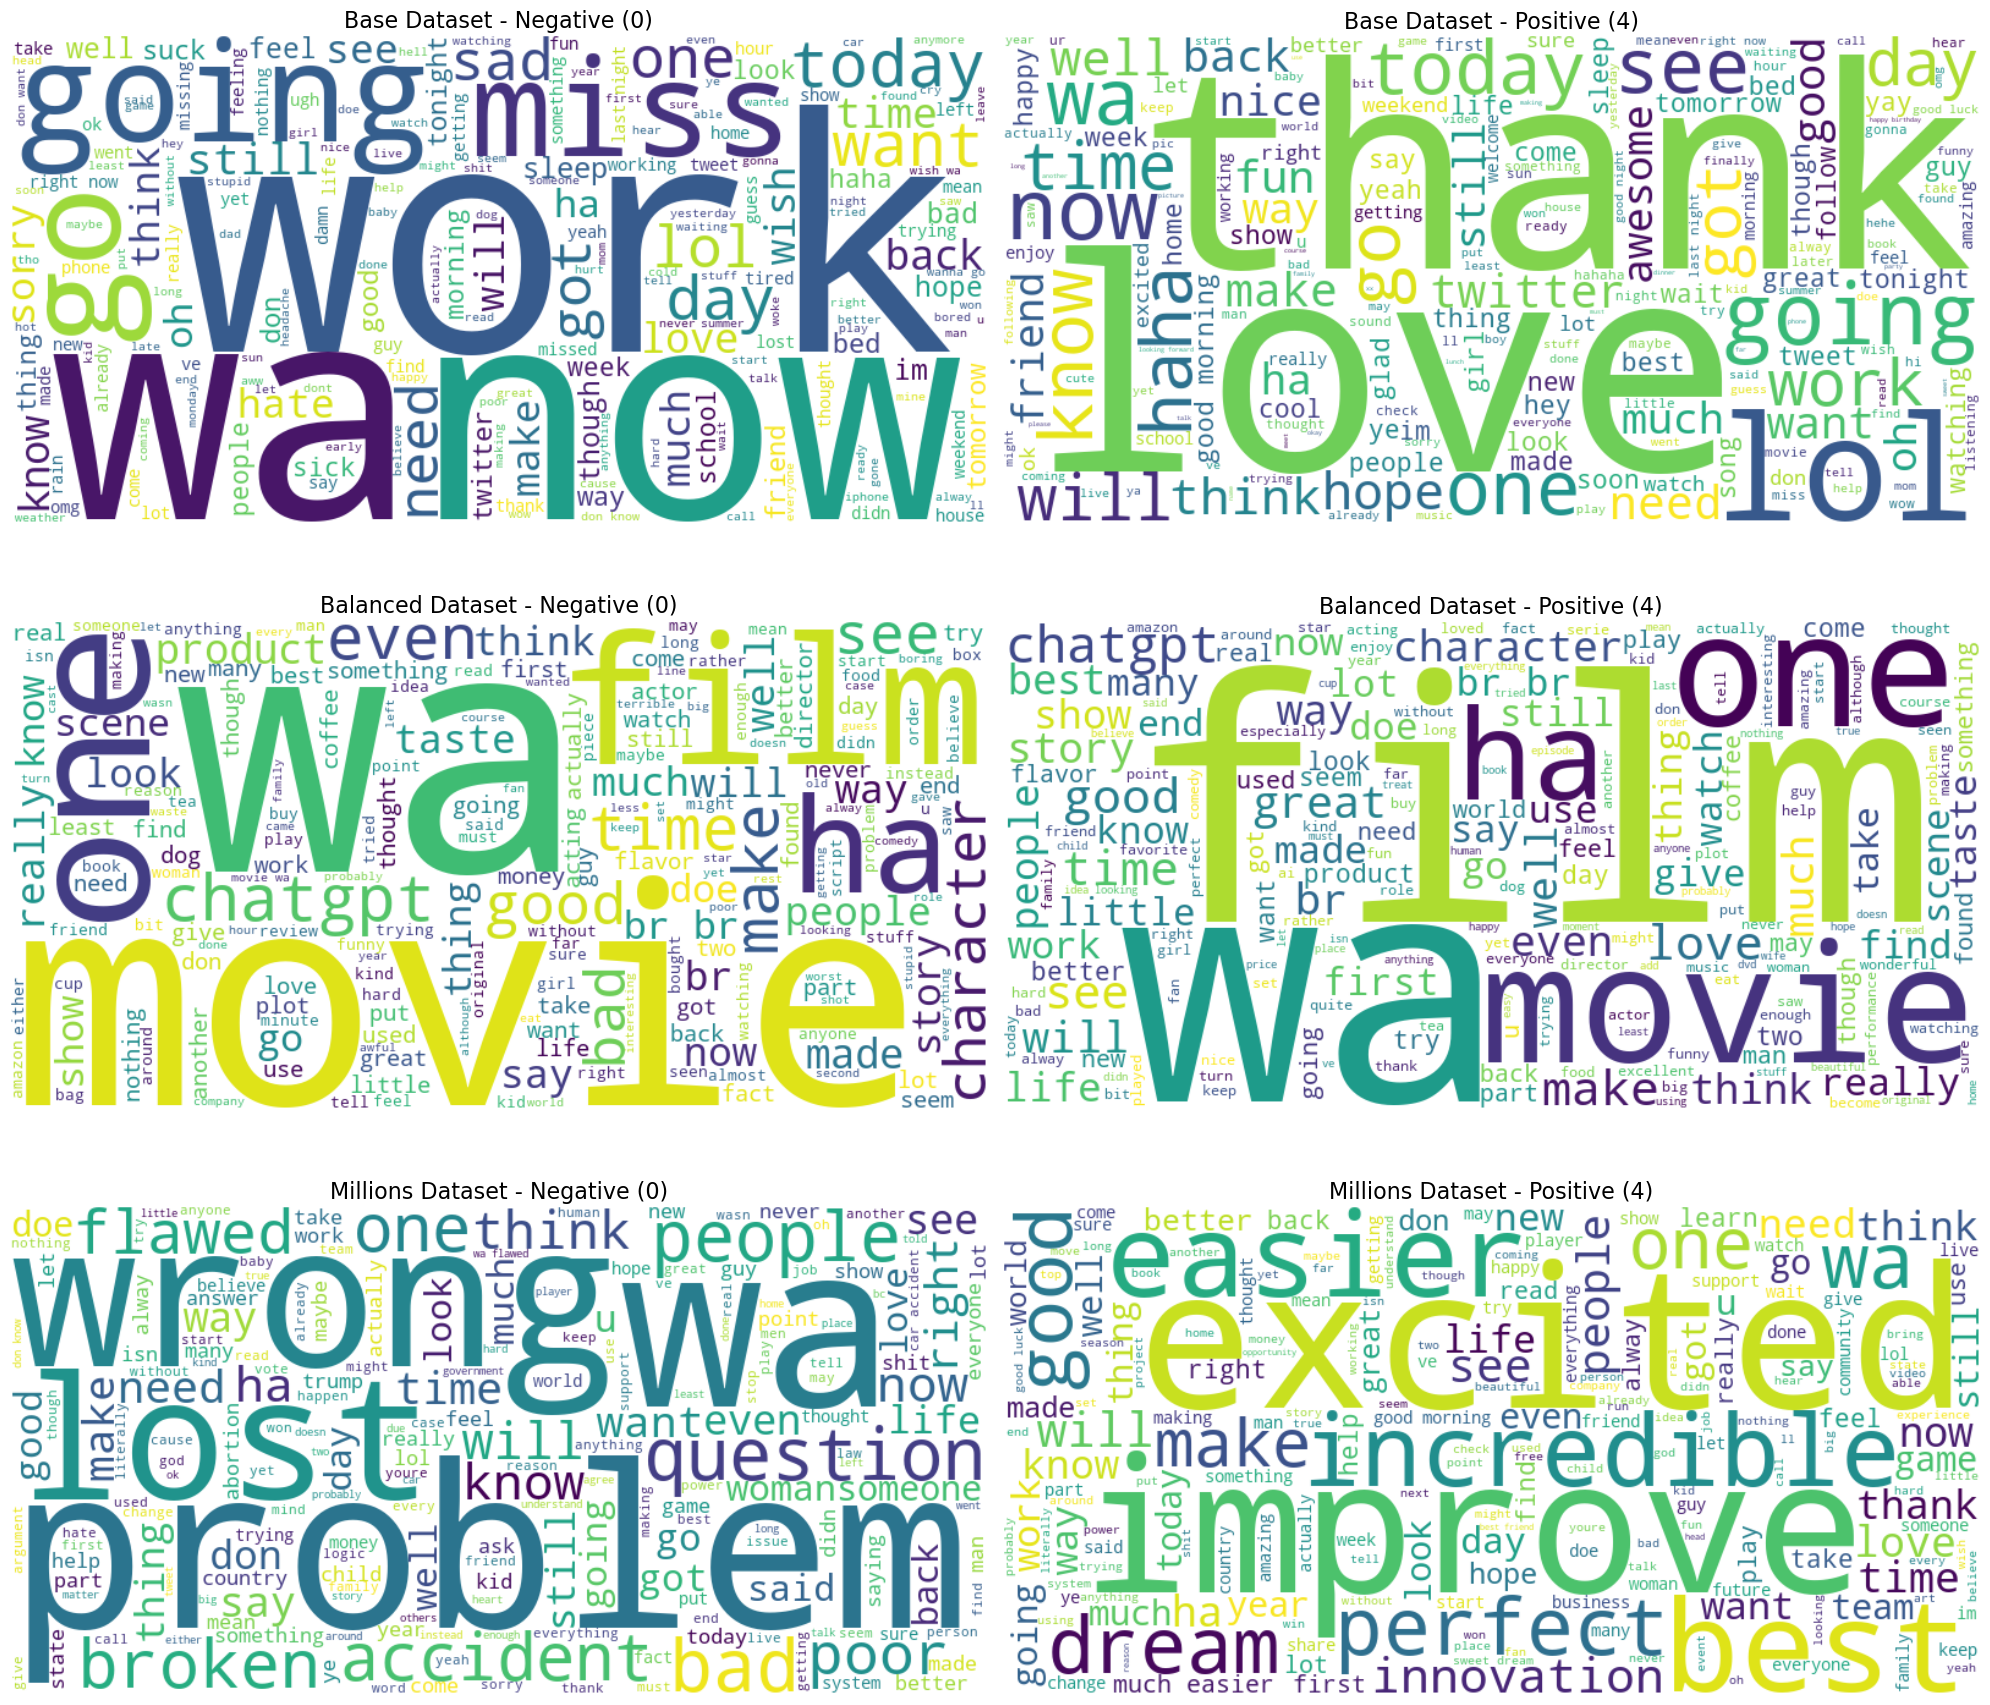

In [26]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# --------------------------
# 1. Prepare Stopwords
# --------------------------
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT'])  # Remove common tokens

# --------------------------
# 2. Function to Generate Word Cloud
# --------------------------
def generate_wordcloud(text_data, title):
    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   stopwords=stopwords,
                   max_words=200).generate(" ".join(text_data.dropna().astype(str)))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')

# --------------------------
# 3. Separate Positive & Negative for Each Dataset
# --------------------------
datasets = [
    ("Base Dataset", df),
    ("Balanced Dataset", balanced_sentiment),
    ("Millions Dataset", million_sentiment)
]

# --------------------------
# 4. Plot Word Clouds (2 columns per dataset: Negative & Positive)
# --------------------------
fig, axs = plt.subplots(3, 2, figsize=(20, 18))

for i, (name, dataset) in enumerate(datasets):
    # Negative (target = 0)
    negative_text = dataset[dataset['target'] == 0]['cleaned_text']
    plt.sca(axs[i, 0])
    generate_wordcloud(negative_text, f"{name} - Negative (0)")

    # Positive (target = 4)
    positive_text = dataset[dataset['target'] == 4]['cleaned_text']
    plt.sca(axs[i, 1])
    generate_wordcloud(positive_text, f"{name} - Positive (4)")

plt.tight_layout()
plt.show()


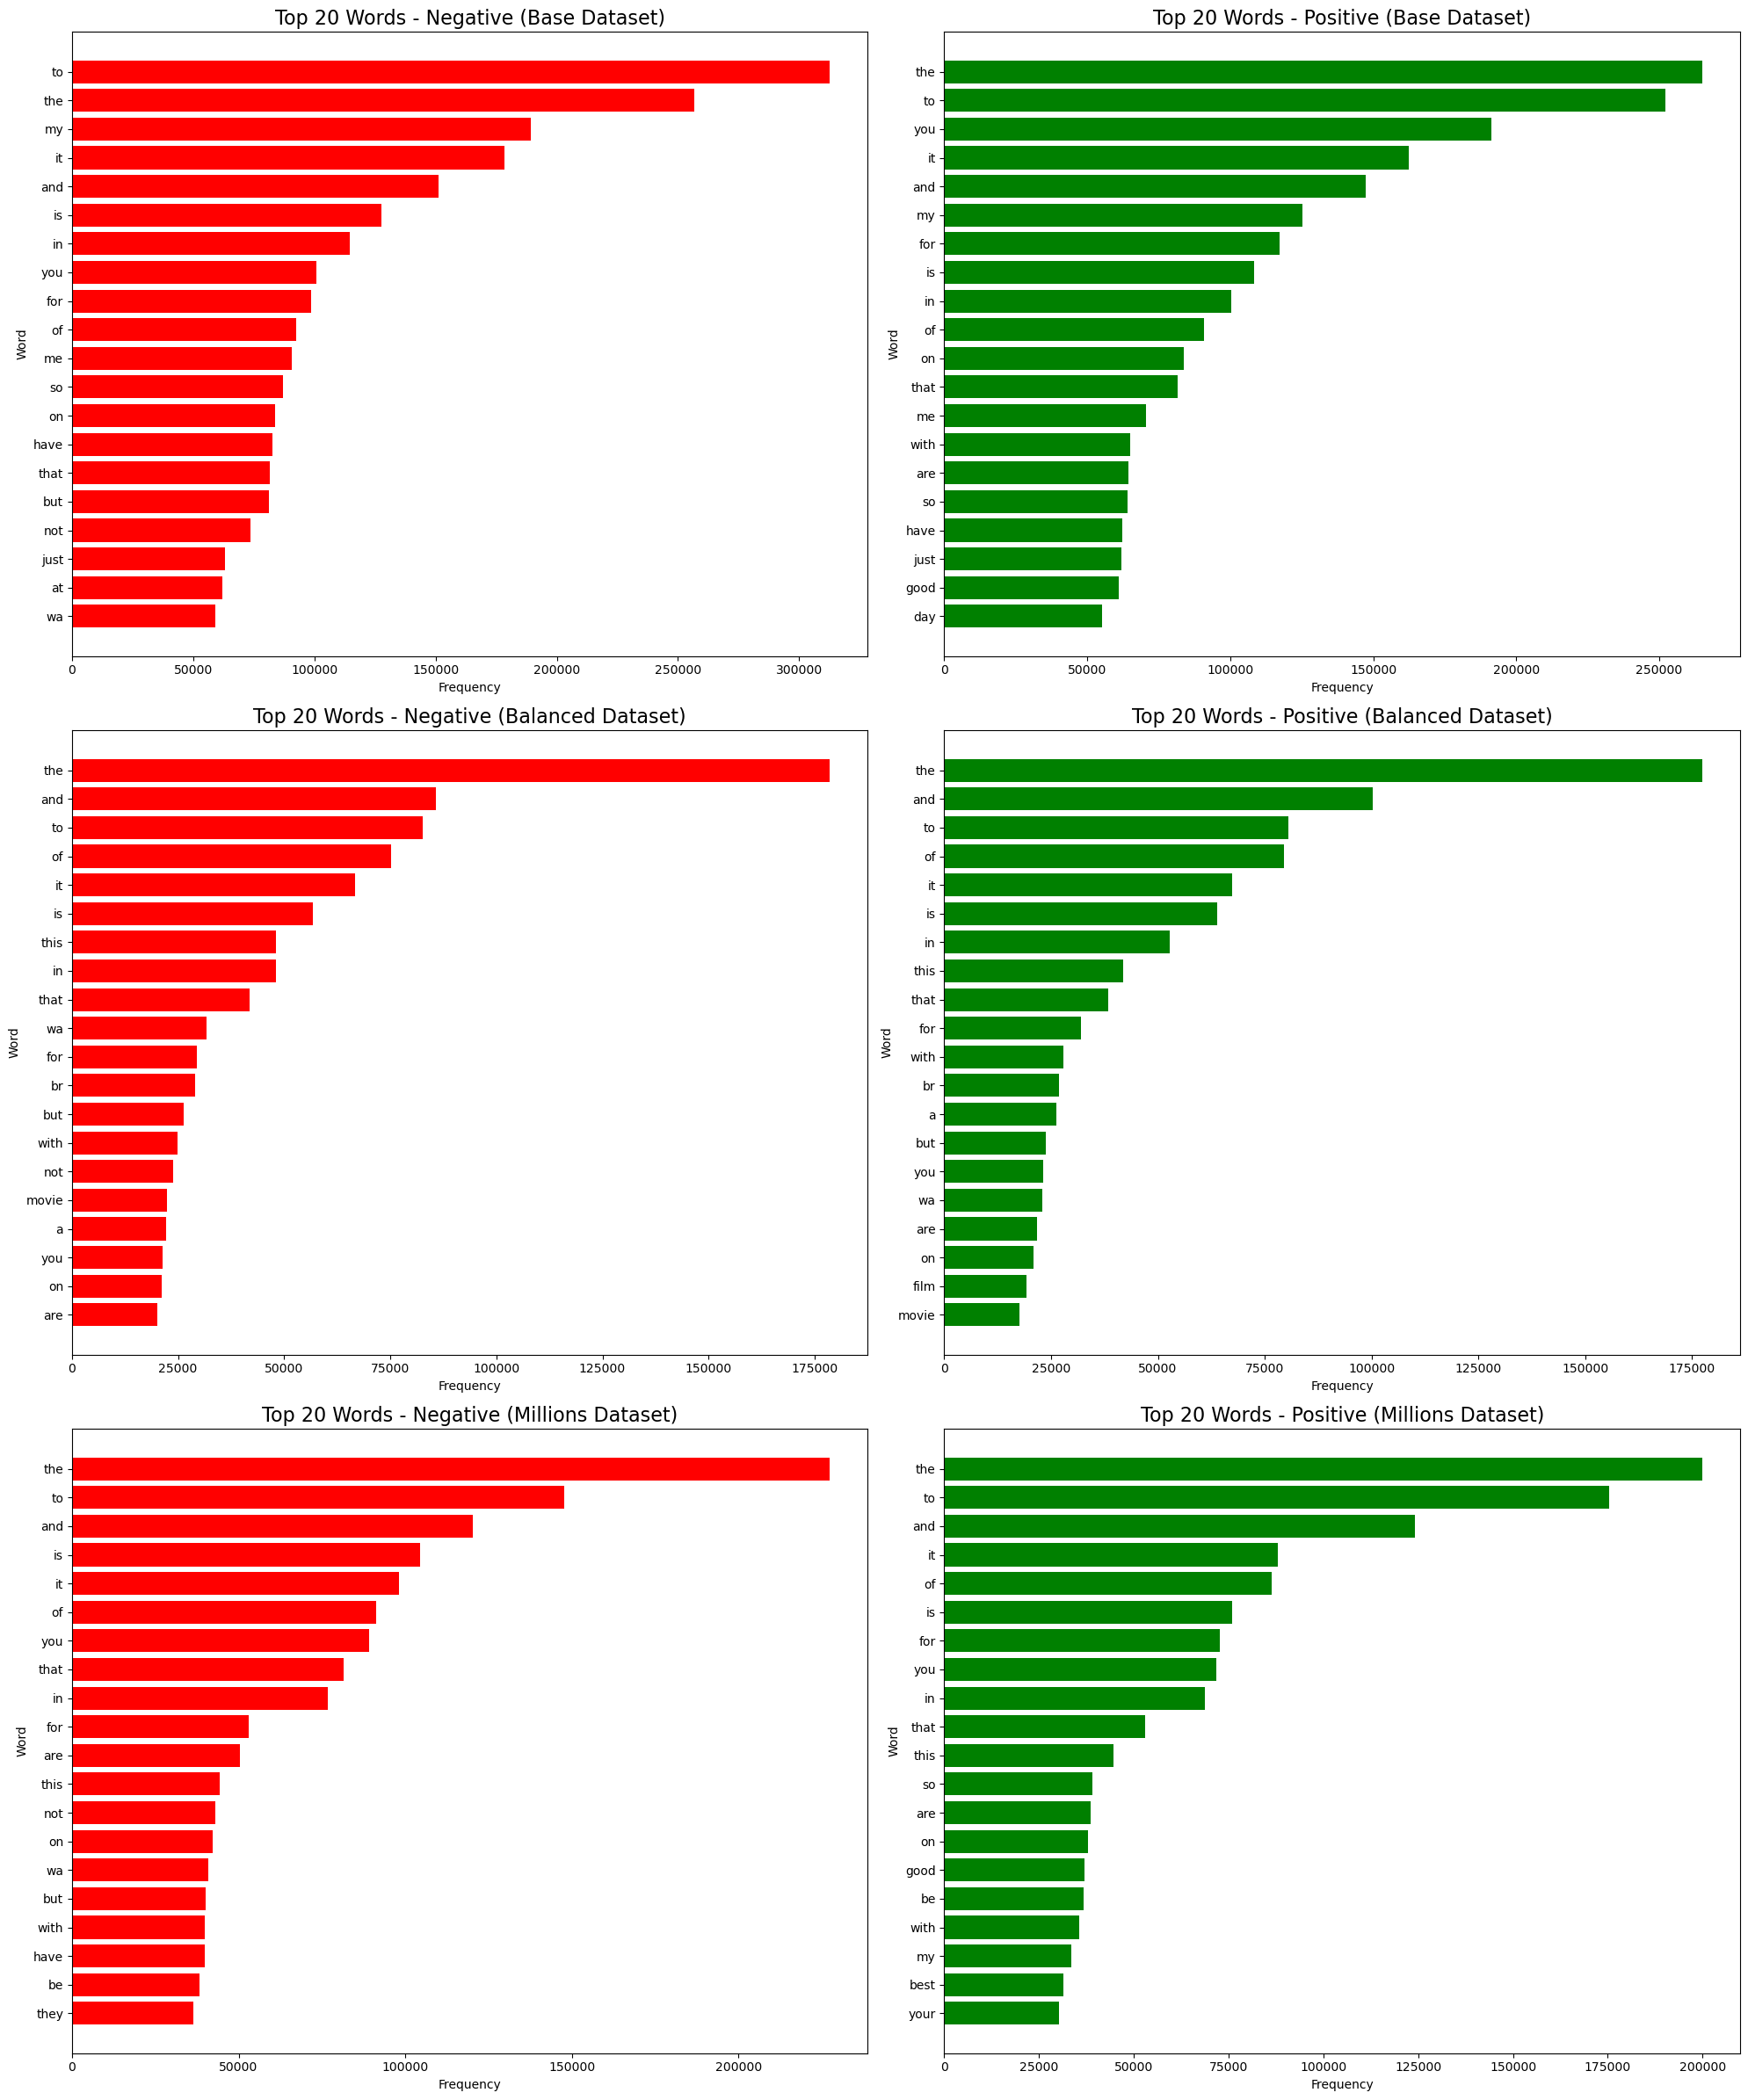

In [27]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# --------------------------
# 1. Function to get top words
# --------------------------
def get_top_words(text_series, top_n=20):
    all_words = " ".join(text_series.dropna().astype(str)).split()
    word_counts = Counter(all_words)
    return pd.DataFrame(word_counts.most_common(top_n), columns=['Word', 'Frequency'])

# --------------------------
# 2. Prepare datasets
# --------------------------
datasets = [
    ("Base Dataset", df),
    ("Balanced Dataset", balanced_sentiment),
    ("Millions Dataset", million_sentiment)
]

# --------------------------
# 3. Create Subplots (3 datasets × 2 sentiments)
# --------------------------
fig, axs = plt.subplots(3, 2, figsize=(20, 24))  # 3 rows, 2 columns

for i, (name, dataset) in enumerate(datasets):
    # Top 20 Negative words
    negative_words = get_top_words(dataset[dataset['target'] == 0]['cleaned_text'], 20)
    axs[i, 0].barh(negative_words['Word'], negative_words['Frequency'], color='red')
    axs[i, 0].invert_yaxis()
    axs[i, 0].set_title(f'Top 20 Words - Negative ({name})', fontsize=16)
    axs[i, 0].set_xlabel('Frequency')
    axs[i, 0].set_ylabel('Word')

    # Top 20 Positive words
    positive_words = get_top_words(dataset[dataset['target'] == 4]['cleaned_text'], 20)
    axs[i, 1].barh(positive_words['Word'], positive_words['Frequency'], color='green')
    axs[i, 1].invert_yaxis()
    axs[i, 1].set_title(f'Top 20 Words - Positive ({name})', fontsize=16)
    axs[i, 1].set_xlabel('Frequency')
    axs[i, 1].set_ylabel('Word')

plt.tight_layout()
plt.show()
